In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ksa-delivery-transport-10000-rows/ksa_delivery_transport_10000_rows.csv


Dataset '/kaggle/input/ksa-delivery-transport-10000-rows/ksa_delivery_transport_10000_rows.csv' Loaded Successfully.
Shape: (10000, 17)


,shipment_id,shipment_category,origin_city,destination_city,distance_km,transport_mode,weight_kg,volume_m3,delivery_time_days,cost_SAR,fuel_cost_SAR,carrier_type,delivery_status,pickup_datetime,dropoff_datetime,num_packages,customer_type
0,SH000001,food,Riyadh,Makkah,285.0,small_van,44.83,0.24,1,419.83,149.53,3PL,in_transit,2023-08-05 18:21:03,2023-08-06 19:21:03,3,B2C
1,SH000002,livestock,Riyadh,Riyadh,28.7,motorbike,21.69,0.07,1,58.73,25.70,3PL,on_time,2023-12-28 10:13:36,2023-12-29 18:13:36,5,B2C
2,SH000003,furniture,Hail,Abha,95.5,small_van,399.41,1.02,1,148.55,82.49,in_house,on_time,2025-07-04 09:25:01,2025-07-05 13:25:01,2,B2C
3,SH000004,electronics,Abha,Madinah,177.5,cargo_van,89.10,0.32,1,355.11,143.98,3PL,in_transit,2023-12-01 11:28:43,2023-12-02 16:28:43,6,B2C
4,SH000005,food,Abha,Jeddah,198.6,cargo_van,39.22,0.11,1,391.79,153.69,postal_service,delayed,2025-07-26 20:32:16,2025-07-28 00:32:16,3,B2C


Encoding categorical columns: ['shipment_category', 'origin_city', 'destination_city', 'transport_mode', 'carrier_type', 'customer_type']
Preprocessing Complete.


,shipment_category,origin_city,destination_city,distance_km,transport_mode,weight_kg,volume_m3,carrier_type,num_packages,customer_type,pickup_hour,day_of_week,delivery_duration_hours
0,4,8,7,285.0,5,44.83,0.24,0,3,1,18,5,25.0
1,7,8,8,28.7,3,21.69,0.07,0,5,1,10,3,32.0
2,5,2,0,95.5,5,399.41,1.02,1,2,1,9,4,28.0
3,3,0,6,177.5,0,89.10,0.32,0,6,1,11,4,29.0
4,4,0,4,198.6,0,39.22,0.11,2,3,1,20,5,28.0


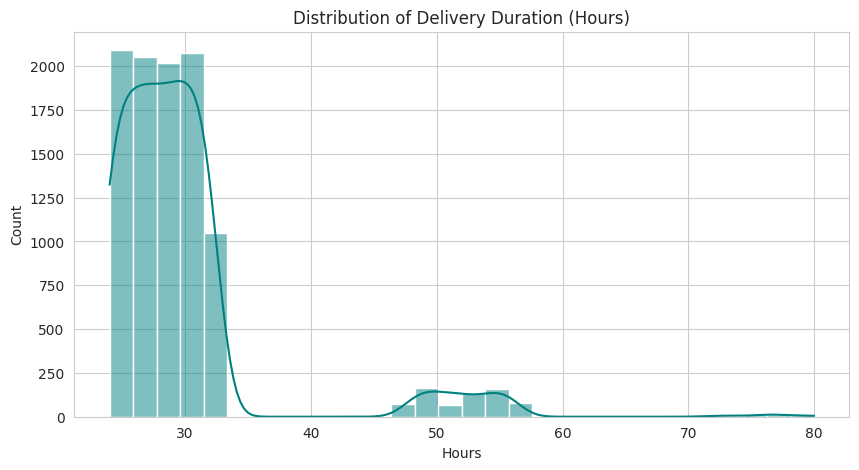

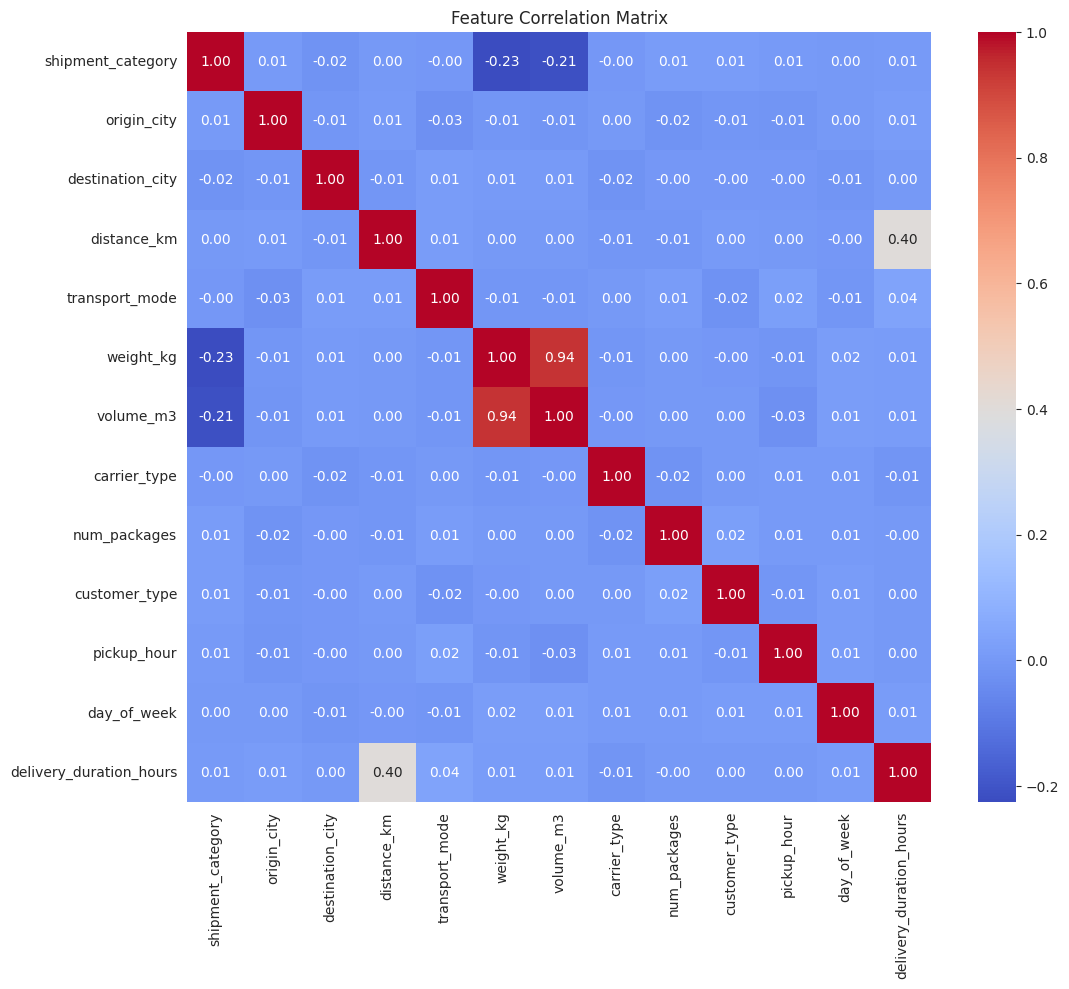

Training Features Shape: (8000, 12)
Testing Features Shape: (2000, 12)
Linear Regression RMSE: 6.31 hours
Decision Tree RMSE: 9.22 hours
Starting Hyperparameter Tuning (XGBoost)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

--- Final Model Performance ---
XGBoost RMSE: 5.82 hours
XGBoost R2 Score: 0.2869


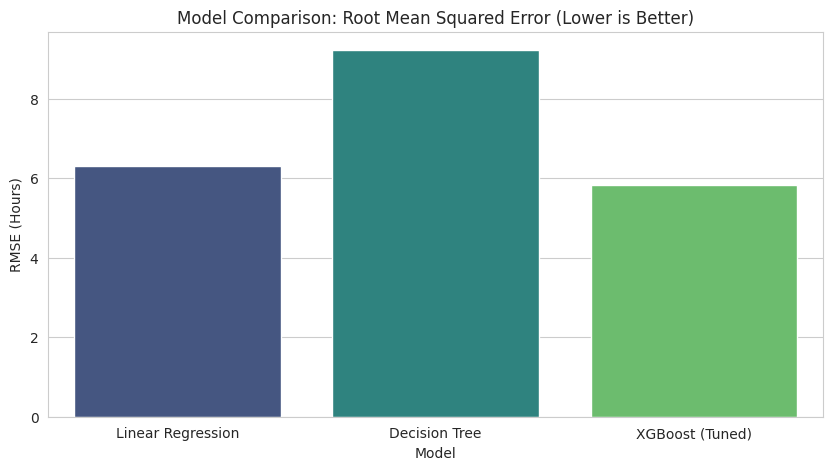

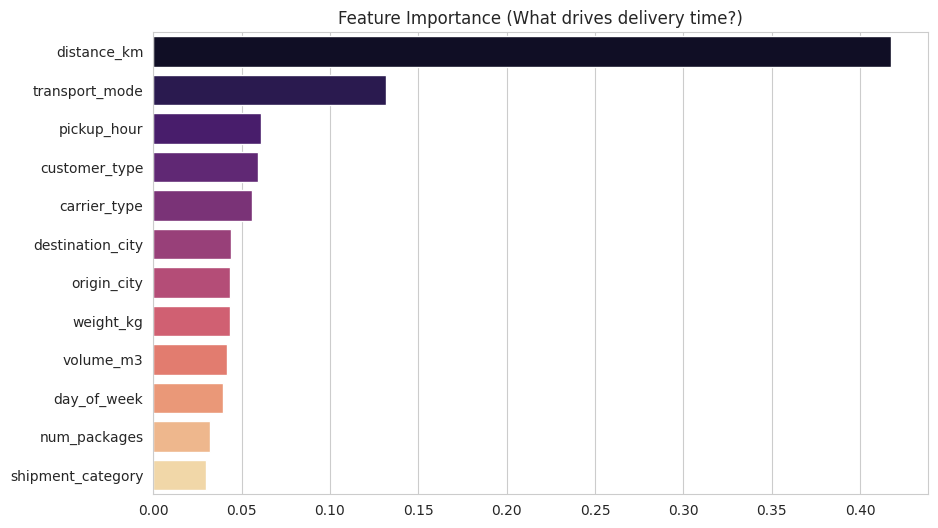

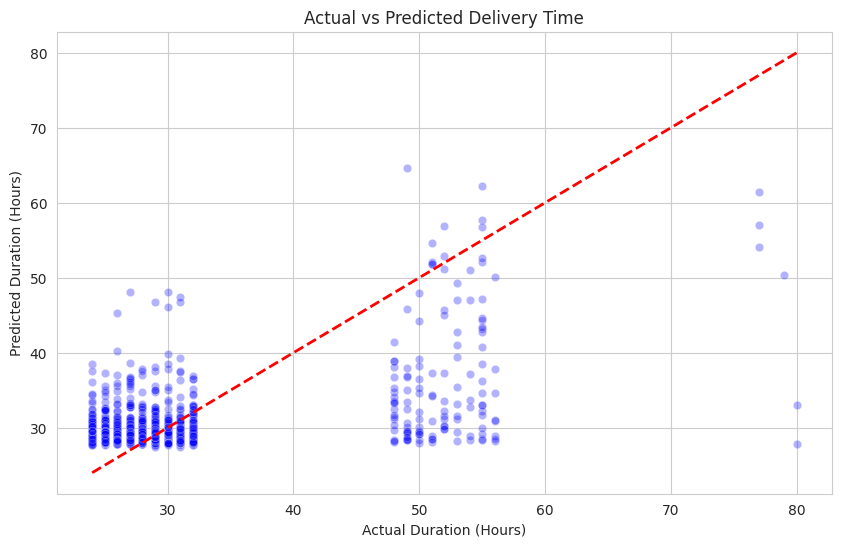

In [17]:
# %% [code]
# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression  # Baseline 1
from sklearn.tree import DecisionTreeRegressor     # Baseline 2
from xgboost import XGBRegressor
import warnings

warnings.filterwarnings('ignore')

# Set visual style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# %% [code]
# 2. LOAD DATASET
file_name = '/kaggle/input/ksa-delivery-transport-10000-rows/ksa_delivery_transport_10000_rows.csv'

try:
    df = pd.read_csv(file_name)
    print(f"Dataset '{file_name}' Loaded Successfully.")
    print("Shape:", df.shape)
    display(df.head())
except FileNotFoundError:
    print(f"Error: '{file_name}' not found. Please upload the file.")

# %% [code]
# 3. DATA PREPROCESSING & FEATURE ENGINEERING

# 3.1 Convert Datetime Columns
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# 3.2 Create Target Variable: Delivery Duration (in Hours)
# We calculate precise time difference instead of using the rounded 'delivery_time_days'
df['delivery_duration_hours'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 3600

# 3.3 Extract Date Features (Useful for traffic patterns)
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek # 0=Monday, 6=Sunday

# 3.4 Select Features for the Model
# We drop ID (useless), dates (we extracted features), and 'delivery_status' (this is an outcome, we can't know it beforehand!)
# We also drop 'fuel_cost_SAR' and 'cost_SAR' as they are likely calculated *after* the trip or derived from time/distance.
features_to_keep = [
    'shipment_category', 'origin_city', 'destination_city', 
    'distance_km', 'transport_mode', 'weight_kg', 
    'volume_m3', 'carrier_type', 'num_packages', 'customer_type',
    'pickup_hour', 'day_of_week', 'delivery_duration_hours' # Target
]

df_model = df[features_to_keep].copy()

# 3.5 Encode Categorical Variables
label_encoders = {}
categorical_cols = df_model.select_dtypes(include=['object']).columns

print(f"Encoding categorical columns: {list(categorical_cols)}")

for col in categorical_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le

# 3.6 Handle Outliers/Errors (Negative or zero time)
df_model = df_model[df_model['delivery_duration_hours'] > 0]

print("Preprocessing Complete.")
display(df_model.head())

# %% [code]
# 4. EXPLORATORY DATA ANALYSIS (EDA)

# Target Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_model['delivery_duration_hours'], bins=30, kde=True, color='teal')
plt.title('Distribution of Delivery Duration (Hours)')
plt.xlabel('Hours')
plt.show()

# Correlation Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df_model.corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

# %% [code]
# 5. SPLIT DATA
X = df_model.drop(columns=['delivery_duration_hours'])
y = df_model['delivery_duration_hours']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")

# %% [code]
# 6. BASELINE COMPARISON (Required for Project)

results = {}

# Baseline 1: Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
results['Linear Regression'] = lr_rmse
print(f"Linear Regression RMSE: {lr_rmse:.2f} hours")

# Baseline 2: Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_pred))
results['Decision Tree'] = dt_rmse
print(f"Decision Tree RMSE: {dt_rmse:.2f} hours")

# %% [code]
# 7. MAIN MODEL: XGBOOST WITH HYPERPARAMETER TUNING

# Define Parameter Grid for Randomized Search
param_dist = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb = XGBRegressor(random_state=42, n_jobs=-1)

print("Starting Hyperparameter Tuning (XGBoost)...")
search = RandomizedSearchCV(
    xgb, 
    param_distributions=param_dist, 
    n_iter=10, # Try 10 random combinations
    cv=3,      # 3-fold Cross Validation
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

best_model = search.best_estimator_
print(f"Best Parameters: {search.best_params_}")

# Evaluate Best Model
xgb_pred = best_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

results['XGBoost (Tuned)'] = xgb_rmse

print(f"\n--- Final Model Performance ---")
print(f"XGBoost RMSE: {xgb_rmse:.2f} hours")
print(f"XGBoost R2 Score: {xgb_r2:.4f}")

# %% [code]
# 8. RESULTS VISUALIZATION

# 8.1 Model Comparison
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'RMSE'])
plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='RMSE', data=results_df, palette='viridis')
plt.title('Model Comparison: Root Mean Squared Error (Lower is Better)')
plt.ylabel('RMSE (Hours)')
plt.show()

# 8.2 Feature Importance
plt.figure(figsize=(10, 6))
feature_importance = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_importance, y=feature_importance.index, palette='magma')
plt.title('Feature Importance (What drives delivery time?)')
plt.show()

# 8.3 Actual vs Predicted Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=xgb_pred, alpha=0.3, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # Perfect prediction line
plt.xlabel('Actual Duration (Hours)')
plt.ylabel('Predicted Duration (Hours)')
plt.title('Actual vs Predicted Delivery Time')
plt.show()